# Self-supervised deblending by inversion (CRG domain)

**Authors: Nick Luiken, Matteo Ravasi - KAUST**

In this notebook, we perform deblending by inversion similar to `SSDeblending_CCG-pnp`. However we mimic a different acquisition scenario where it becomes more natural to perform denoising in the CRG domain

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import time
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import segyio
import pylops

from torch.utils.data import TensorDataset, DataLoader
from ssdeblend.pnp import Blending
from ssdeblend.model.ssstructdenoise import NoiseNetwork
from ssdeblend.pnp import plug_n_play
from ssdeblend.utils import set_seed

Let's set the device to use our GPU of choice

In [2]:
torch.cuda.empty_cache()

device = 'cuda:0'
print(torch.cuda.get_device_name(device))

NVIDIA GeForce RTX 3090


## Data loading

Following the same procedure detailed in `SSDeblending_CCG-denoising` we load the MobilAVO dataset. A pre-processing step is however applied to resort the data in what would have been an equivalent ocean-bottom acquisition layout

In [3]:
# Load data
f = segyio.open('../data/MobilAVO.segy', ignore_geometry=True)
data = segyio.collect(f.trace[:])
data = data.reshape(1001, 120, 1500)

# Rearrange data
ns = 64 # number of sources
nr = 120 # number of receivers
nt = 1024 # number of time samples
dt = 0.004 # time sampling (sec)
dr = 25 # receiver sampling (m)
data = data[:ns, :, :nt]

# Define axes
t = dt * np.arange(nt)
xr = np.arange(0, nr*dr, dr)

gx =f.attributes(segyio.TraceField.GroupX)[:]
sx =f.attributes(segyio.TraceField.SourceX)[:]
gz =-f.attributes(segyio.TraceField.ReceiverGroupElevation)[:]
sz =-f.attributes(segyio.TraceField.SourceSurfaceElevation)[:]
dr = np.diff(gx)[0]
ds = np.diff(sx[::nr])[0]
dt = (f.samples[1]-f.samples[0])/1000

t = f.samples/1000

In [4]:
nr = 60
data = np.flip(data, axis=1)
data_aligned = np.zeros_like(data)

data_aligned[0] = data[0]
for ishot in range(1, ns):
    data_aligned[ishot, :-ishot] = data[ishot, ishot:]
data_aligned = data_aligned[:nr, :nr]    

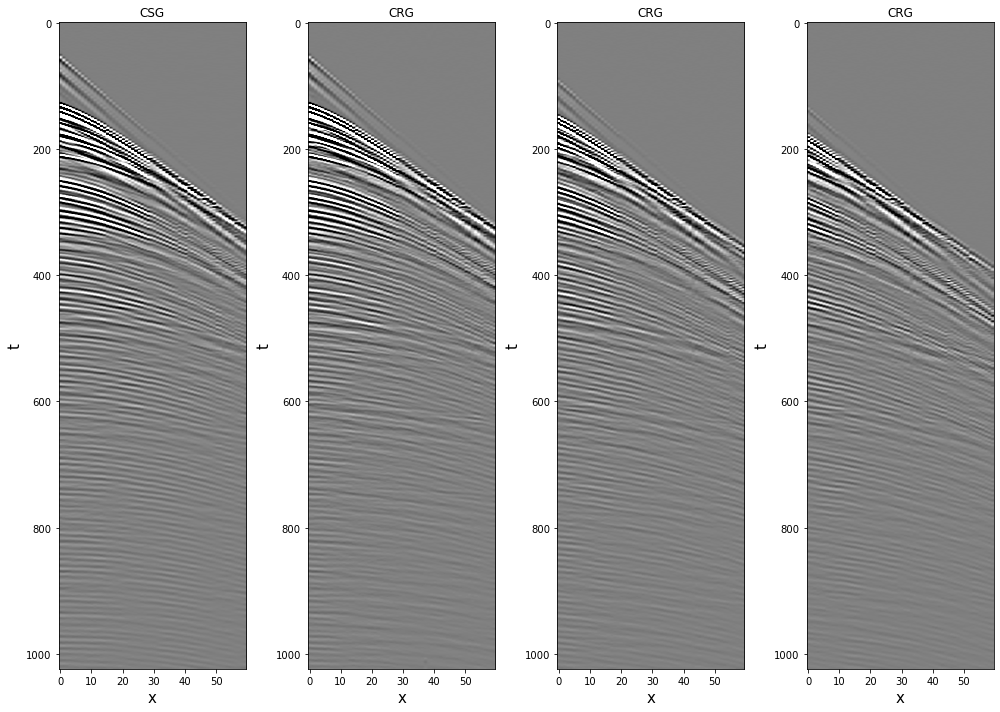

In [5]:
fig, axs = plt.subplots(1, 4, figsize=(14, 10))
axs[0].imshow(data_aligned[1, :, :].T, aspect='auto', vmin=-100, vmax=100, cmap='gray')
axs[0].set_xlabel('x',fontsize=15)
axs[0].set_ylabel('t',fontsize=15)
axs[0].set_title('CSG')
axs[1].imshow(data_aligned[:, 1, :].T, aspect='auto', vmin=-100, vmax=100, cmap='gray')
axs[1].set_xlabel('x',fontsize=15)
axs[1].set_ylabel('t',fontsize=15)
axs[1].set_title('CRG')
axs[2].imshow(data_aligned[:, 10, :].T, vmin=-100, vmax=100, aspect='auto', cmap='gray')
axs[2].set_xlabel('x',fontsize=15)
axs[2].set_ylabel('t',fontsize=15)
axs[2].set_title('CRG')
axs[3].imshow(data_aligned[:, 20, :].T, aspect='auto', cmap='gray', vmin=-100, vmax=100)
axs[3].set_xlabel('x',fontsize=15)
axs[3].set_ylabel('t',fontsize=15)
axs[3].set_title('CRG')
plt.tight_layout()

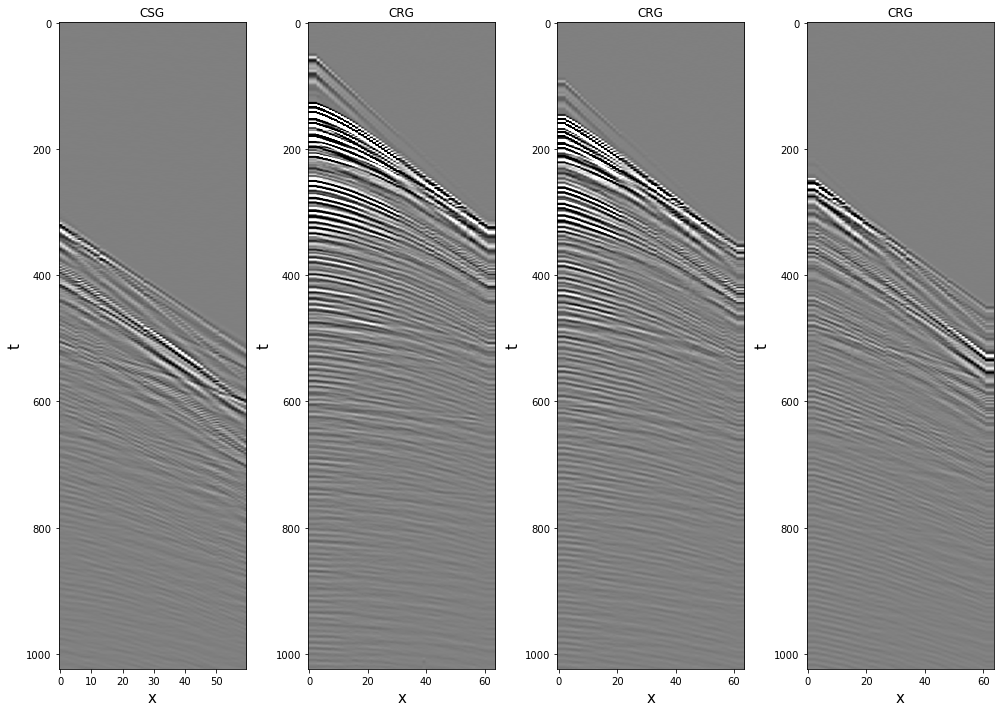

In [6]:
# Add shot gathers to have 64 x 1024 receiver gathers (this is to be able to perform downsampling/upsampling in UNet )
data_aligned_copy = np.zeros((64, nr, nt))
data_aligned_copy[0, :, :] = data_aligned[0, :nr, :]
data_aligned_copy[1, :, :] = data_aligned[0, :nr, :]
data_aligned_copy[-1, :, :] = data_aligned[-1, :nr, :]
data_aligned_copy[-2, :, :] = data_aligned[-1, :nr, :]
data_aligned_copy[2:-2, :, :] = data_aligned

fig, axs = plt.subplots(1, 4, figsize=(14, 10))
axs[0].imshow(data_aligned_copy[-1, :, :].T, aspect='auto', vmin=-100, vmax=100, cmap='gray')
axs[0].set_xlabel('x',fontsize=15)
axs[0].set_ylabel('t',fontsize=15)
axs[0].set_title('CSG')
axs[1].imshow(data_aligned_copy[:, 1, :].T, aspect='auto', vmin=-100, vmax=100, cmap='gray')
axs[1].set_xlabel('x',fontsize=15)
axs[1].set_ylabel('t',fontsize=15)
axs[1].set_title('CRG')
axs[2].imshow(data_aligned_copy[:, 10, :].T, vmin=-100, vmax=100, aspect='auto', cmap='gray')
axs[2].set_xlabel('x',fontsize=15)
axs[2].set_ylabel('t',fontsize=15)
axs[2].set_title('CRG')
axs[3].imshow(data_aligned_copy[:, 40, :].T, aspect='auto', cmap='gray', vmin=-100, vmax=100)
axs[3].set_xlabel('x',fontsize=15)
axs[3].set_ylabel('t',fontsize=15)
axs[3].set_title('CRG')
plt.tight_layout()

At this point we design our blending strategy.

In [7]:
# Create blending times
set_seed(42) # we set here the seed for reproducibility
overlap = 0.5
ignition_times = -1 + 2*np.random.rand(ns)
ignition_times[0] = 0 # set the first time dither to 0

# Blending operator
BlendingOp = Blending(nt, nr, ns, dt, overlap, ignition_times, nproc=20)

In [8]:
print('Ignition times', ignition_times)

Ignition times [ 0.          0.90142861  0.46398788  0.19731697 -0.68796272 -0.68801096
 -0.88383278  0.73235229  0.20223002  0.41614516 -0.95883101  0.9398197
  0.66488528 -0.57532178 -0.63635007 -0.63319098 -0.39151551  0.04951286
 -0.13610996 -0.41754172  0.22370579 -0.72101228 -0.4157107  -0.26727631
 -0.08786003  0.57035192 -0.60065244  0.02846888  0.18482914 -0.90709917
  0.2150897  -0.65895175 -0.86989681  0.89777107  0.93126407  0.6167947
 -0.39077246 -0.80465577  0.36846605 -0.11969501 -0.75592353 -0.00964618
 -0.93122296  0.8186408  -0.48244004  0.32504457 -0.37657785  0.04013604
  0.09342056 -0.63029109  0.93916926  0.55026565  0.87899788  0.7896547
  0.19579996  0.84374847 -0.823015   -0.60803428 -0.90954542 -0.34933934
 -0.22264542 -0.45730194  0.65747502 -0.28649335]


We are now ready to blend our data ($d_b = B d_c$) and apply pseudo deblending to it ($d_{pd} = B^H d_b$)

In [9]:
blended_data = BlendingOp * data_aligned_copy.ravel()
pseudodeblended_data = BlendingOp.H * blended_data
pseudodeblended_data = pseudodeblended_data.reshape(ns, nr, nt)

## Deblending by inversion

We are now ready to solve the deblending problem. The entire procedure is executed inside the `plug_n_play` routine

In [10]:
t0=time.time()
deblended_data_x, deblended_data_y, network_out, error_x, error_y = \
    plug_n_play(BlendingOp, blended_data.ravel(), eps=1e0, shapes=(ns, nr, nt), outer_its=20, 
                inner_its=3, denoiser_epochs=20, x_true=data_aligned_copy.ravel(), device=device)
deblended_data_x = deblended_data_x.reshape(ns, nr, nt)
deblended_data_y = deblended_data_y.reshape(ns, nr, nt)
print(f'Elapsed Time: {(time.time() - t0)/60} mins')

Outer iteration:  0
0.7366302073778991
0.8291962130881703
Outer iteration:  1
0.5862356927146146
0.5457965298904289
Outer iteration:  2
0.3862885521711442
0.32435444398672525
Outer iteration:  3
0.29931204024674124
0.2804015967965014
Outer iteration:  4
0.29483056982859035
0.25819847615390124
Outer iteration:  5
0.2638430779842915
0.25937154737521906
Outer iteration:  6
0.264648053691666
0.24829170697873332
Outer iteration:  7
0.24917313508646843
0.23204736503566373
Outer iteration:  8
0.23231295167833627
0.22654142176464753
Outer iteration:  9
0.231778300012135
0.22014950769058356
Outer iteration:  10
0.22531854127715625
0.2030978985131648
Outer iteration:  11
0.20950760955789713
0.20262959691767113
Outer iteration:  12
0.21019402206598253
0.18639187019277903
Outer iteration:  13
0.19199927260605285
0.16917919001424958
Outer iteration:  14
0.17776495808979004
0.1590990735500996
Outer iteration:  15
0.16785929020979842
0.14431044136054297
Outer iteration:  16
0.15189480324163396
0.1328

## Plots

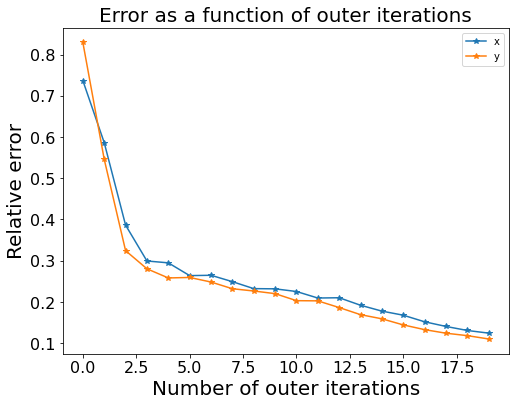

In [11]:
plt.figure(figsize=(8,6))
plt.plot(error_x, '*-', label='x')
plt.plot(error_y, '*-', label='y')
plt.xlabel('Number of outer iterations', fontsize=20)
plt.ylabel('Relative error', fontsize=20)
plt.title('Error as a function of outer iterations', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend();

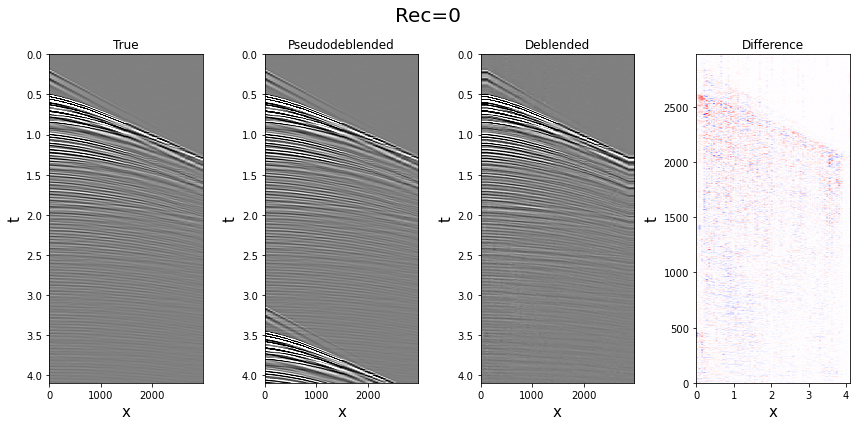

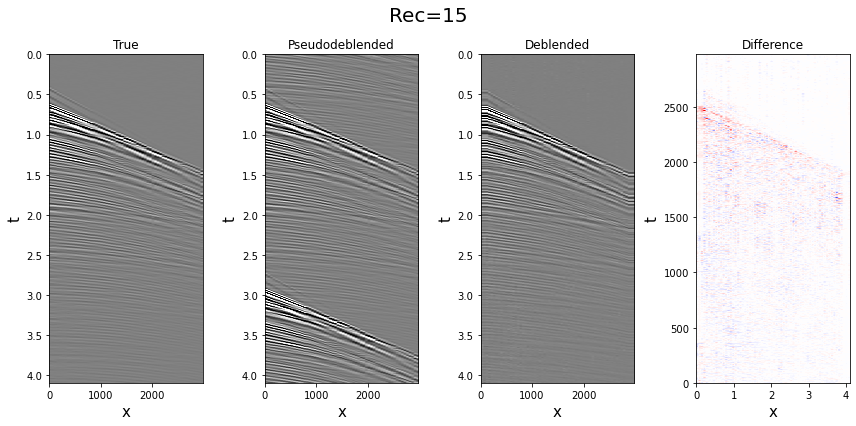

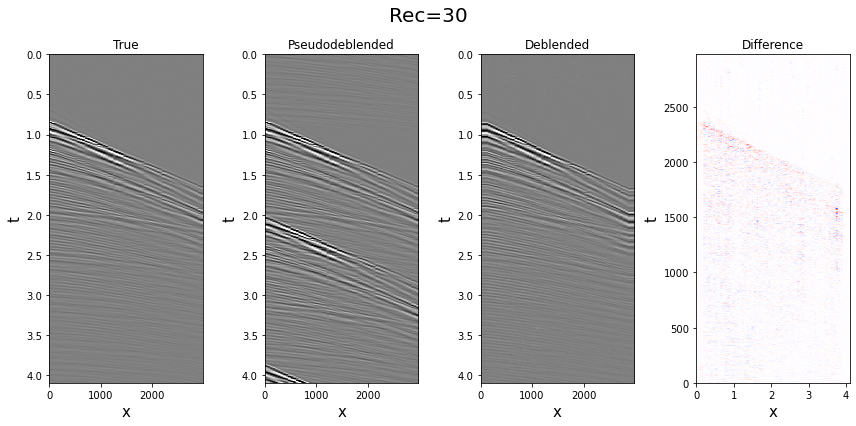

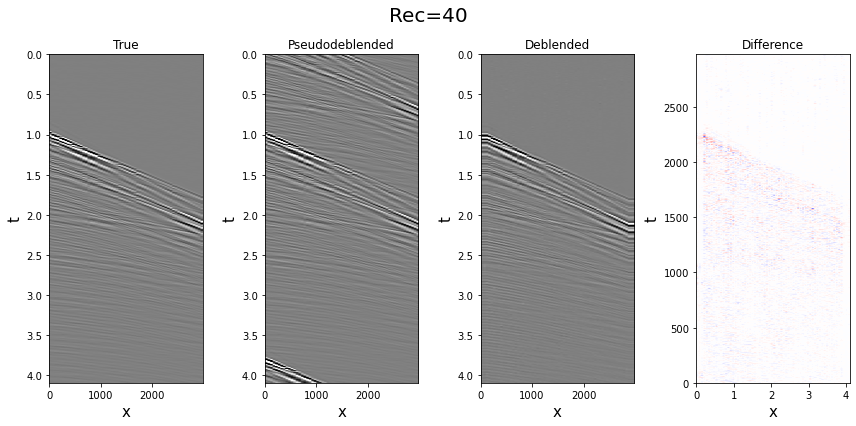

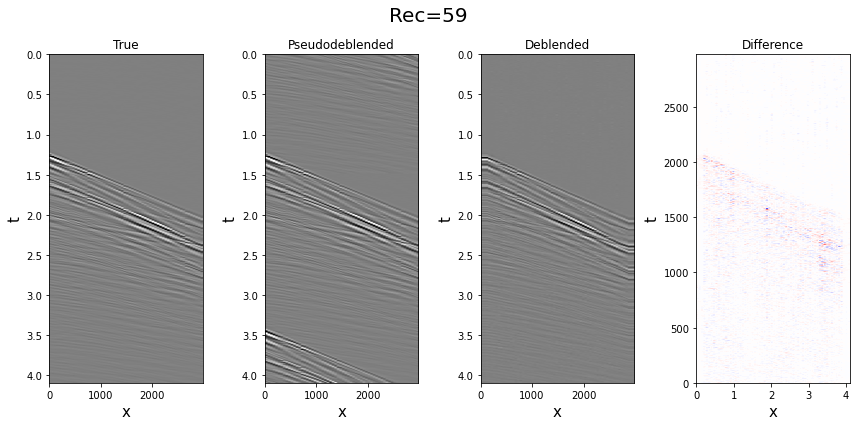

In [12]:
idxs = [0, nr//4, nr//2, 2*nr//3, nr-1]

for idx in idxs:
    fig, axs = plt.subplots(1, 4, figsize=(12, 6))
    fig.suptitle(f'Rec={idx}',fontsize=20)
    axs[0].imshow(data_aligned_copy[idx].T.real, aspect='auto', vmin=-100, vmax=100, cmap='gray', 
                  extent=(xr.min(), xr.max(), t.max(), t.min()))
    axs[0].set_xlabel('x',fontsize=15)
    axs[0].set_ylabel('t',fontsize=15)
    axs[0].set_title('True')
    axs[1].imshow(pseudodeblended_data[idx, :, :].T.real, aspect='auto', 
                  vmin=-100, vmax=100, cmap='gray',
                  extent=(xr.min(), xr.max(), t.max(), t.min()))
    axs[1].set_xlabel('x',fontsize=15)
    axs[1].set_ylabel('t',fontsize=15)
    axs[1].set_title('Pseudodeblended')
    axs[2].imshow(deblended_data_x[:, idx].T.real, aspect='auto', vmin=-100, vmax=100, cmap='gray',
                  extent=(xr.min(), xr.max(), t.max(), t.min()))
    axs[2].set_xlabel('x',fontsize=15)
    axs[2].set_ylabel('t',fontsize=15)
    axs[2].set_title('Deblended')
    axs[3].imshow((data_aligned_copy[:, idx] - deblended_data_x[:, idx]).T.real, 
                  aspect='auto', vmin=-100, vmax=100,
                  cmap='seismic', extent=(t.min(), t.max(), xr.min(), xr.max()))
    axs[3].set_xlabel('x',fontsize=15)
    axs[3].set_ylabel('t',fontsize=15)
    axs[3].set_title('Difference')
    plt.tight_layout();

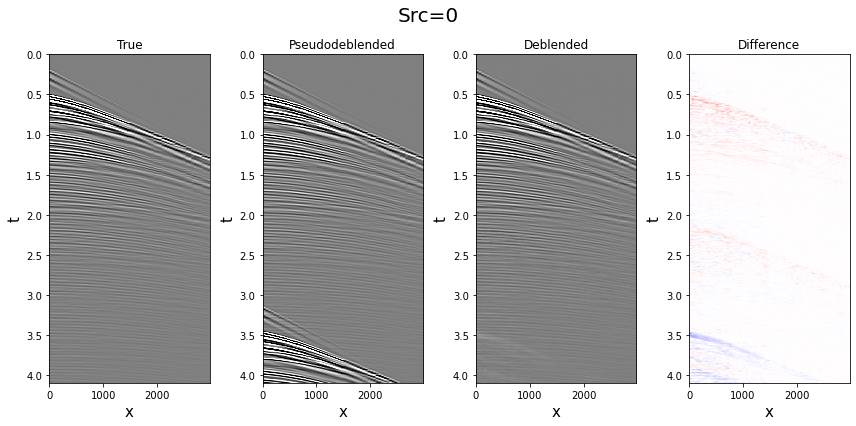

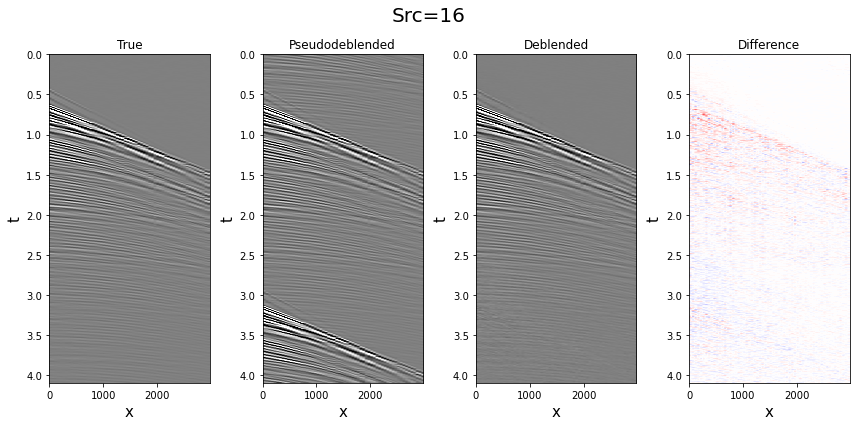

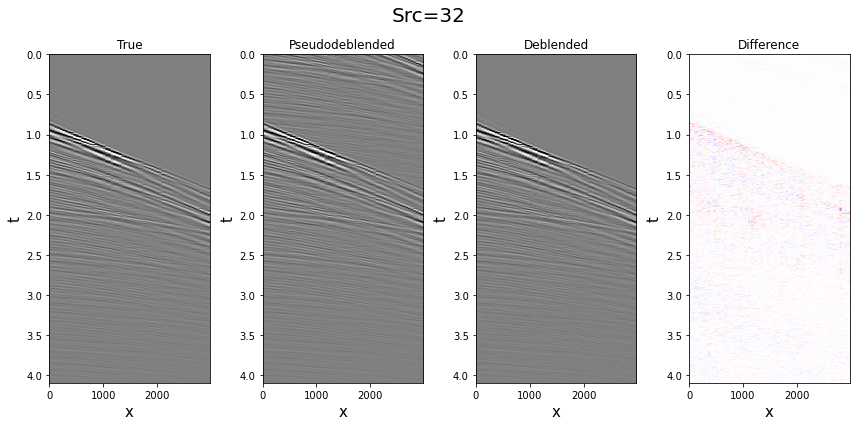

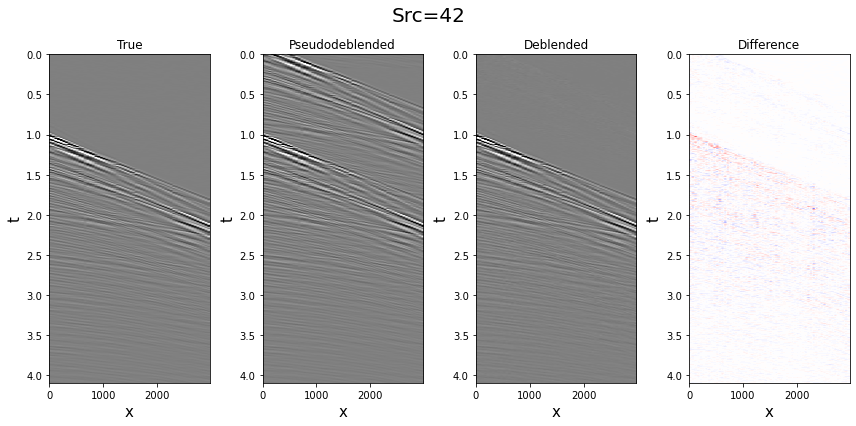

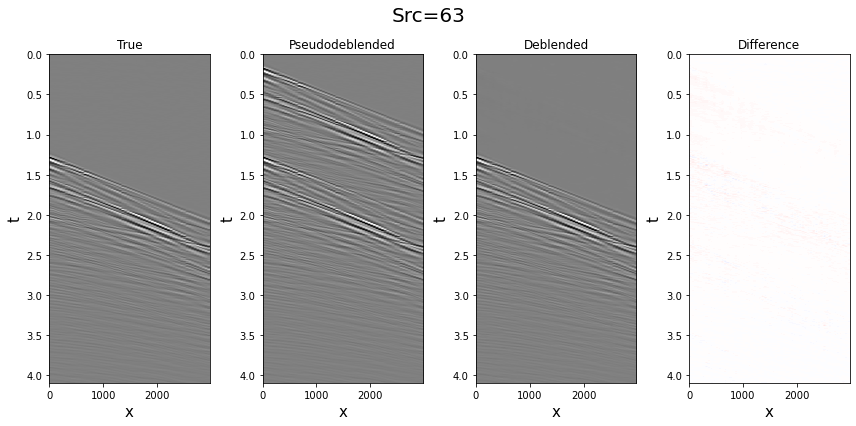

In [13]:
idxs = [0, ns//4, ns//2, 2*ns//3, ns-1]

for idx in idxs:
    fig, axs = plt.subplots(1, 4, figsize=(12, 6))
    fig.suptitle(f'Src={idx}',fontsize=20)
    axs[0].imshow(data_aligned_copy[idx].T.real, aspect='auto', vmin=-100, vmax=100, cmap='gray', 
                  extent=(xr.min(), xr.max(), t.max(), t.min()))
    axs[0].set_xlabel('x',fontsize=15)
    axs[0].set_ylabel('t',fontsize=15)
    axs[0].set_title('True')
    axs[1].imshow(pseudodeblended_data[idx].T.real, aspect='auto', 
                  vmin=-100, vmax=100, cmap='gray',
                  extent=(xr.min(), xr.max(), t.max(), t.min()))
    axs[1].set_xlabel('x',fontsize=15)
    axs[1].set_ylabel('t',fontsize=15)
    axs[1].set_title('Pseudodeblended')
    axs[2].imshow(deblended_data_x[idx].T.real, aspect='auto', vmin=-100, vmax=100, cmap='gray',
                  extent=(xr.min(), xr.max(), t.max(), t.min()))
    axs[2].set_xlabel('x',fontsize=15)
    axs[2].set_ylabel('t',fontsize=15)
    axs[2].set_title('Deblended')
    axs[3].imshow((data_aligned_copy[idx] - deblended_data_x[idx]).T.real, 
                  aspect='auto', vmin=-100, vmax=100, cmap='seismic',
                  extent=(xr.min(), xr.max(), t.max(), t.min()))
    axs[3].set_xlabel('x',fontsize=15)
    axs[3].set_ylabel('t',fontsize=15)
    axs[3].set_title('Difference')
    plt.tight_layout();

In [14]:
error_deblended = np.linalg.norm(deblended_data_x.ravel() - data_aligned_copy.ravel()) / np.linalg.norm(data_aligned_copy.ravel())
print(f'Total RMSE (X):{error_deblended}')

error_deblended = np.linalg.norm(deblended_data_y.ravel() - data_aligned_copy.ravel()) / np.linalg.norm(data_aligned_copy.ravel())
print(f'Total RMSE (Y):{error_deblended}')

Total RMSE (X):0.12435683241000325
Total RMSE (Y):0.11021068545530444
